### <span style="color:white">Welcome</span>

This Jupiter notebook will present my workflow of analyzing and visualizing a dataset from Kaggle.

The data in this set had been scrapped from an employment website named "indeed" and it's related to the data positions domain

you can view the source in this link: https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us



In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re 
import nltk
#nltk.download() #download nltk data corpora

In [2]:
df = pd.read_csv("original_data.csv", encoding='utf-8')
print(df.columns)
print(df.info()) 

Index(['position', 'company', 'description', 'reviews', 'location'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6953 entries, 0 to 6952
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     6953 non-null   object 
 1   company      6953 non-null   object 
 2   description  6953 non-null   object 
 3   reviews      5326 non-null   float64
 4   location     6953 non-null   object 
dtypes: float64(1), object(4)
memory usage: 271.7+ KB
None


In [3]:
df.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


### <span style="color:red">data cleaning</span>
* Removing blank rows
* Break the location to: city, state, zip code
* Convert the text to lowercase letters and remove the empty lines  


##### dealing with NULL VALUES

In [4]:
df.dropna(axis=0, how='all', inplace=True)   # Remove blank rows
df.reviews.fillna(value=0 , inplace=True)    # Change NULL reviews to 0 reviews

##### dealing with state and city names

In [5]:
city = []
state = []
zip_code = []

for i, location in enumerate(df.location):
    city.append(location.split(',')[0])
    state.append(location.split(',')[1][1:3])
    zip_code.append(location.split(',')[1][4:].rstrip())

City = pd.Series(city)
State = pd.Series(state)
Zip_code = pd.Series(zip_code)

df = df.assign(city=City.values, state=State.values , zip_code=Zip_code .values)
df.drop('location', inplace=True, axis=1)
df.head()

,position,company,description,reviews,city,state,zip_code
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,0.0,Atlanta,GA,30301
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",0.0,Atlanta,GA,
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",0.0,Atlanta,GA,
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,Atlanta,GA,30303
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,Atlanta,GA,


##### convert to lowercase letters

In [6]:
def first_cleaning(text):
    text = str(text)
    text = text.replace("\n"," ")
    return text.lower() 

In [7]:
df.description = df.description.apply(first_cleaning)
df.position	= df.position.apply(first_cleaning)
df.company = df.company.apply(first_cleaning)

### <span style="color:red">Formatting with Regular Expressions</span>
Using Regex I will locate the email and URL hiding in the description text.

I will create new empty lists and insert to them the email and URL.

For more info on Regex using python, you can view this link: https://docs.python.org/3/library/re.html 

In [8]:
website_columns = [None for x in range(len(df))]
email_columns = [None for x in range(len(df))]

In [9]:
for i in range(len(df)):
    # position_text = str(df.loc[i, "position"])
    description_text = str(df.loc[i, "description"])

    # data_professional = re.compile(r'[\w]+[\s]data[\s][\w]+')
    website_pattern = re.compile(r'(https?):\/\/([\w_-]+(?:(?:\.[\w_-]+)+)[\w.,@?^=%&:\/~+#-]*[\w@?^=%&~+#-])')
    email_pattern = re.compile(r'[\w\.-]+@\w+.[\w.]+[^\.\s]')
    
    website_matches = website_pattern.findall(description_text)
    email_matches = email_pattern.findall(description_text)
    re.sub(website_pattern, '', description_text)
    re.sub(email_pattern, '', description_text)

    for match in website_matches:
        website_columns[i] = match[1]   
    
    for match in email_matches:
        email_columns[i] = match

df["website"] = pd.Series(website_columns)
df["email"] = pd.Series(email_columns)

In [10]:
from string import punctuation #remove all: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ from text
    
def second_cleaning(text):
    '''remove punctuation and remove words containing numbers.'''
    text = re.sub('[%s]' % re.escape(punctuation), ' ', text)
    text = re.sub('[-"&\(\)\\\/]', ' ', text)
    text = re.sub('[—:]', ' ', text)
    text = re.sub('[‘’“”…]', ' ', text)
    text = re.sub('[.]', ' ', text)
    return text
df.description = df.description.apply(second_cleaning)
df.position = df.position.apply(second_cleaning)

##### Saving the clean data frame to csv

In [11]:
df.to_csv('cleaned_data.csv',index=False, header=df.columns)

###  <span style="color:red">Language Processing</span>
* Split the text into single words - tokenizing
* Remove stop words they don't give us new knowledge
* I haven't performed lemmatization and steaming because I didn't want to change the concept definition.  

In [12]:
from nltk.corpus import stopwords #remove all: anybody, anyhow, anyone, anyways, anywhere, are ...
from nltk.tokenize import word_tokenize 

##### tokenizing and Removing Stopwords

In [13]:
#tokenizing example
first_desc = df.loc[1, "description"]
stop_words = set(stopwords.words("english"))
words = word_tokenize(first_desc)
print("number of word before removing the stopwords: "+str(len(words)))
filtered_sentence = [W for W in words if W not in stop_words]
print("number of word after removing the stopwords: "+str(len(filtered_sentence)))
print("example of text after tokenizing: ", filtered_sentence[0:10])

number of word before removing the stopwords: 603
number of word after removing the stopwords: 400
example of text after tokenizing:  ['job', 'description', 'road', 'leads', 'accomplishment', 'narrow', 'desmond', 'ostentatious', 'strong', 'adjective']


In [14]:
def remove_stop_word(text):
    return [W for W in text if W not in stop_words]

In [15]:
df = df.drop([448, 2442], axis=0)                                              #remove row with problem with tokenizing 
df["description"] = df["description"].apply(nltk.word_tokenize)                #tokenizing
df["description"] = df["description"].apply(remove_stop_word)                  #remove stop word
df["position"] = df["position"].apply(nltk.word_tokenize)                      #tokenizing
df["position"] = df["position"].apply(remove_stop_word)                        #remove stop word

###  <span style="color:red">Classifying</span>
* extract important key word and classifying by position title and skills


In [16]:
position_list = ['development director','research assistant','data scientist','data analyst',
                 'assistant professor','product specialist','geologist',
                 'structural engineer','electrical engineer','epidemiologist','finance analyst',
                 'full stack developer','health scientist','microbiologist','data engineer','bi analyst', 
                 'ecologist','malware analyst','biomedical engineer','software engineer','devops engineer','research, technician',
                 'cyber security systems engineer','web developer','front end engineer','digital marketing','bookkeeper',
                 'statistical analyst','ml scientist','mobile, developer', 'deep learning scientist', 'machine learning engineer']


tools_list = ['python',' sql ','java','scala','excel','aws ','hadoop','spark',
             'linux','tableau','linux',' sas ','hive','oracle','perl', ' etl ',
             'mysql','matlab','html','tensorflow','spss','mongodb', ' r ']

skills_list = ['machine learning','data analysis','data visualization',
            'modeling','statistical analysis','research','deep learning',
            'optimization','decision tree','logistic','random forest',
            'ab testing','web scraping','neural network','interpersonal skills',
            'communication skills','artificial intelligence']

degree_list = ['master','phd ','bachelor','high school','No degree requirement']

major_list = ['computer science','data science','statistics','quantitative',
            'mathematics','economics','liberal arts','science','business',
            'engineer','engineering','psychology','biology','medicine',
            'marketing','business analysis','chemical engineering','chemistry',
            'public health','public relationship']

In [17]:
def classifying(column,list, descripsion):  
    """      """
    found = 0
    new_list = []
    for text in column:
        temp_list = []
        for values in list:
            if values in " ".join(text) and values not in temp_list:
                temp_list.append(values.strip())
                found+=1
        new_list.append(", ".join(temp_list))
    print(found, descripsion, "match has fund")
    return((new_list))

df["tools"] = classifying(df["description"],tools_list, "tools")
df["skills"] = classifying(df["description"],skills_list, "skills")
df["degree"] = classifying(df["description"],degree_list, "degree title")
df["major"] = classifying(df["description"],major_list, "major")
df["position_category"] = classifying(df["position"],position_list, "position categorys")

20952 tools match has fund
17187 skills match has fund
5991 degree title match has fund
29420 major match has fund
2215 position categorys match has fund


In [18]:
# reordering the dataframe
df = df[['position','position_category', 'company', 'description', 'reviews', 'city', 'state',
       'zip_code', 'tools', 'skills', 'degree', 'major','website', 'email']]
df.position	= df.position.apply(" ".join)
df.loc[df.company == "fred hutchinson cancer research center","company"] = "fred hutchinson" # too long company name walmart ecommerce
df.loc[df.company == "walmart ecommerce","company"] = "walmart"  

In [19]:
df.head()

,position,position_category,company,description,reviews,city,state,zip_code,tools,skills,degree,major,website,email
0,development director,development director,als tdi,"[development, director, als, therapy, developm...",0.0,Atlanta,GA,30301,excel,research,bachelor,business,als.applicantpro.com,None
1,ostentatiously excitable principal research as...,research assistant,the hexagon lavish,"[job, description, road, leads, accomplishment...",0.0,Atlanta,GA,,"scala, excel, r","modeling, statistical analysis, research, logi...",master,"computer science, statistics, quantitative, ma...",None,None
2,data scientist,data scientist,xpert staffing,"[growing, company, located, atlanta, ga, area,...",0.0,Atlanta,GA,,"python, sql, java, hadoop, tableau, oracle, pe...","machine learning, data analysis, modeling, res...",master,"computer science, data science, economics, sci...",None,None
3,data analyst,data analyst,operation hope,"[department, program, operationsposition, loca...",44.0,Atlanta,GA,30303,"python, sql, tableau, sas, r","data visualization, modeling, optimization",bachelor,,None,None
4,assistant professor tt signal processing machi...,assistant professor,emory university,"[description, emory, university, department, b...",550.0,Atlanta,GA,,,"machine learning, research",phd,"computer science, data science, science, engin...",www.atlantactsi.org/areas/bip,None


###  <span style="color:red">visualization</span>

In [20]:
import plotly.express as px

### number of jobs by location

In [21]:
job_count_by_state = df.state.value_counts().sort_values(ascending=False) #Simpler to implementation 
print(job_count_by_state.index)
print(job_count_by_state.values)

Index(['CA', 'MA', 'WA', 'NY', 'IL', 'DC', 'GA', 'CO', 'TX', 'NJ'], dtype='object')
[2152 1322  935  926  471  340  269  251  217   68]


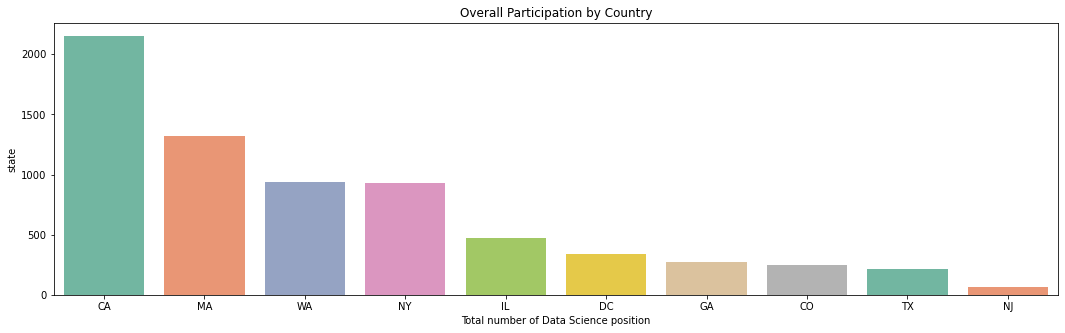

In [22]:
plt.figure(figsize=(18,5))
plt.title('Overall Participation by Country')
plt.xlabel('Total number of Data Science position')
plt.ylabel('location', )
sns.barplot(x=job_count_by_state.index, y=job_count_by_state, palette='Set2');

##### Choropleth Maps


In [23]:
job_count_df = pd.DataFrame(data=None, index=None, columns=['state','job count'])
job_count_df['state'] = job_count_by_state.index
job_count_df['job count'] = job_count_by_state.values

In [24]:
fig = px.choropleth(data_frame=job_count_df, locations='state', locationmode="USA-states",\
                    color='job count', scope="usa",labels={'job count':'total number of positions'},color_continuous_scale="bluered", \
                    width=1000, height=400, title ="job count by state")
fig.show()

### most demanted job

In [25]:
top_job = df.position_category.value_counts().sort_values(ascending=False)[1:15]
top_job

data scientist               1240
software engineer             337
data engineer                 181
data analyst                  125
machine learning engineer     115
research assistant             39
statistical analyst            15
finance analyst                15
geologist                      11
deep learning scientist        10
electrical engineer            10
digital marketing               9
web developer                   8
front end engineer              8
Name: position_category, dtype: int64

In [26]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

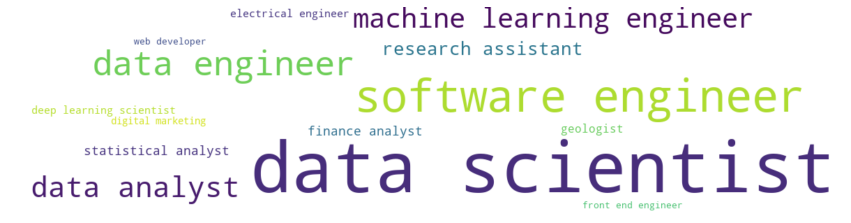

In [27]:
cloud = WordCloud(background_color=(255,255,255),
               max_font_size=100, contour_color=(0,0 ,0), max_words=15,width=1200,height=300)
cloud.generate_from_frequencies(top_job.to_dict())

plt.figure(figsize = (15,10))
# plt.title(r'Word Cloud of top jobs',fontsize=40,pad=50,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### The most recruited companies

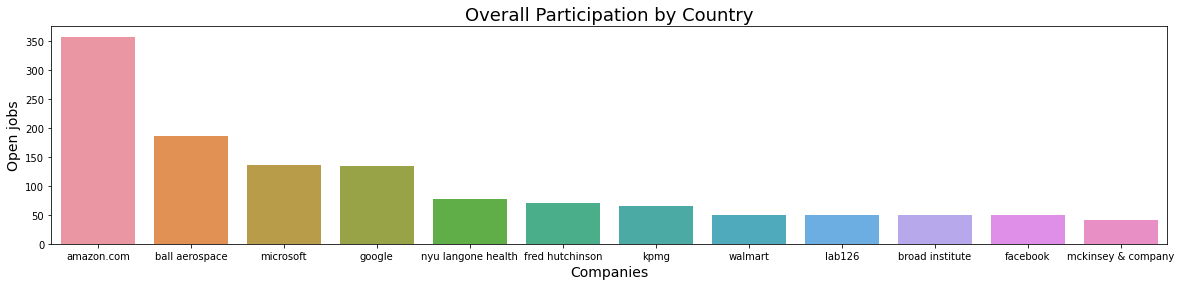

In [28]:
companies = df.company.value_counts(sort=True, ascending=False)[0:12]
plt.figure(figsize=(20,4))
plt.title('Overall Participation by Country',size=18)
plt.xlabel('Companies',size=14)
plt.ylabel('Open jobs',size=14 )
sns.barplot(x=companies.index, y=companies.values)
plt.show()

#### Working with only data related position
- Some of the fields in the data set contain data on non-related data-position such as: geologist, digital marketing, epidemiologist, and more.
- In the following analysis, I will only row with jobs in the data science domain.

In [29]:
data_df = df.loc[df.position_category.isin(['data scientist','data engineer','data analyst','machine learning engineer',
                                            'statistical analyst','deep learning scientist'])]
data_df.head()

,position,position_category,company,description,reviews,city,state,zip_code,tools,skills,degree,major,website,email
2,data scientist,data scientist,xpert staffing,"[growing, company, located, atlanta, ga, area,...",0.0,Atlanta,GA,,"python, sql, java, hadoop, tableau, oracle, pe...","machine learning, data analysis, modeling, res...",master,"computer science, data science, economics, sci...",None,None
3,data analyst,data analyst,operation hope,"[department, program, operationsposition, loca...",44.0,Atlanta,GA,30303,"python, sql, tableau, sas, r","data visualization, modeling, optimization",bachelor,,None,None
5,manager data engineering,data engineer,mckinsey & company,"[qualifications, bachelor, degree, computer, s...",385.0,Atlanta,GA,30318,"sql, aws, hadoop",optimization,bachelor,"computer science, quantitative, science, busin...",www.periscope-solutions.com,None
9,senior associate cognitive data scientist natu...,data scientist,kpmg,"[known, great, place, work, build, career, kpm...",4494.0,Atlanta,GA,30338,"excel, r","machine learning, deep learning, optimization,...",,"computer science, statistics, quantitative, ma...",None,None
12,senior associate data scientist,data scientist,kpmg,"[innovate, collaborate, shine, lighthouse, kpm...",4494.0,Atlanta,GA,30338,"excel, hadoop, spark, linux, hive","machine learning, data visualization, modeling...","master, phd","computer science, data science, statistics, ma...",None,None


#### Junior vs Senior:  **postion** 

In [30]:
data_df["experience"] = classifying(data_df["description"],["junior",'senior'], "positions experience level")

498 positions experience level match has fund


C:\Users\PC\AppData\Local\Temp/ipykernel_22044/4187498215.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
junior_position = data_df.loc[data_df["experience"]=="junior","position_category"].value_counts(sort=True, ascending=False)[0:12]
senior_position = data_df.loc[data_df["experience"]=="senior","position_category"].value_counts(sort=True, ascending=False)[0:12]

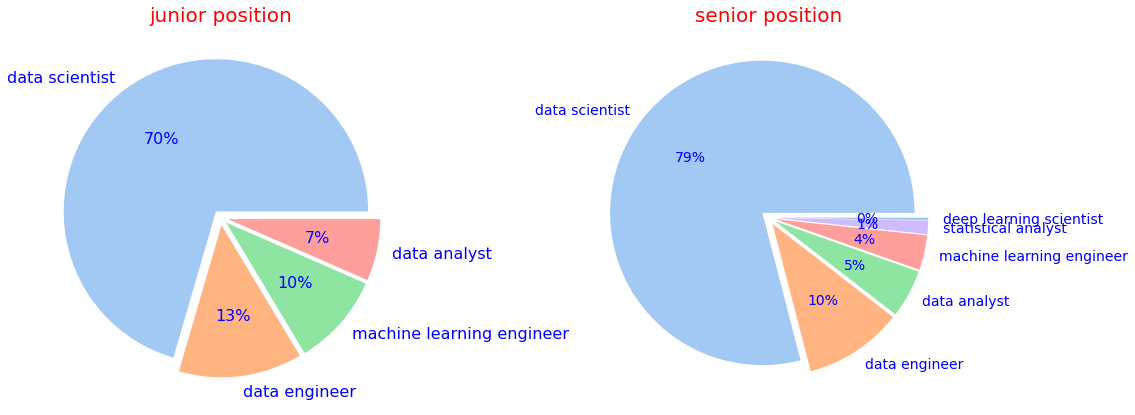

In [32]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
colors = sns.color_palette('pastel')[0:5] #define Seaborn color palette to use
plt.pie(x= junior_position.values, labels = junior_position.index, colors = colors, #create pie chart
        autopct='%.0f%%',explode=len(junior_position.index)*[0.05],
        textprops={'fontsize': 16,'color':"blue"}) 
plt.title("junior position",size=20,color="red")

plt.subplot(1,2,2)
plt.pie(x= senior_position.values, labels = senior_position.index, colors = colors, #create pie chart
        autopct='%.0f%%',explode=len(senior_position.index)*[0.05],
       textprops={'fontsize': 14,'color':"blue"}) 
plt.title("senior position",size=20,color="red")
plt.show()

#### Junior vs Senior:  **Top 5 tools**  

In [33]:
from collections import Counter

In [34]:
def count_tools(list_a):
    q_list = []
    for x in list_a:
        q_list.extend(x.split(","))
    return(Counter(q_list))
    
junior_tools_list= count_tools(data_df.loc[data_df["experience"]=="junior","tools"])
senior_tools_list= count_tools(data_df.loc[data_df["experience"]=="senior","tools"])


In [35]:
junior_tools_value = []
junior_tools_index = []
senior_tools_value = []
senior_tools_index = []
junior_tools = junior_tools_list.most_common()
senior_tools = senior_tools_list.most_common()
for i in range(5):
    junior_tools_value.append(junior_tools[i][1]) 
    junior_tools_index.append(junior_tools[i][0])
    senior_tools_value.append(senior_tools[i][1])
    senior_tools_index.append(senior_tools[i][0])

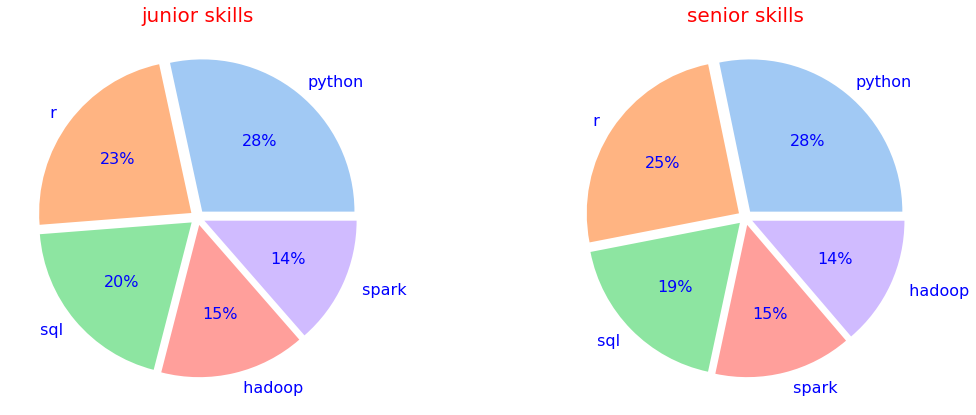

In [36]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
colors = sns.color_palette('pastel')[0:5] #define Seaborn color palette to use
plt.pie(x= junior_tools_value, labels = junior_tools_index, colors = colors, #create pie chart
        autopct='%.0f%%',explode=5*[0.05],
        textprops={'fontsize': 16,'color':"blue"}) 
plt.title("junior skills",size=20,color="red")

plt.subplot(1,2,2)
plt.pie(x= senior_tools_value, labels = senior_tools_index, colors = colors, #create pie chart
        autopct='%.0f%%',explode=(5)*[0.05],
       textprops={'fontsize': 16,'color':"blue"}) 
plt.title("senior skills",size=20,color="red")
# plt.subplots_adjust(0.01)
plt.show()

### Conclusion
* Python is the most demanded tool in your arsenal, following R language.
* Junior and Senior data jobs have similar required tools.
* Seniors are more likely to be data scientists than juniors.
* California has the biggest number of open jobs.

 And most importantly, read the job descriptions carefully, and you'll be hired!